In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from statsmodels.tools.eval_measures import rmse, meanabs
from sklearn.metrics import mean_absolute_percentage_error as mape

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HDSC/Time_series_analysis_and_forecast_DATASET.csv')
df.head()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
1,2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2,2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
3,2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
4,2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [4]:
df['FullDate'] = pd.to_datetime(df['FullDate'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92016 entries, 0 to 92015
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   FullDate   92016 non-null  datetime64[ns]
 1   Tmax       92016 non-null  float64       
 2   SysLoad    92016 non-null  float64       
 3   GasPrice   92016 non-null  float64       
 4   ElecPrice  92016 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 3.5 MB


In [48]:
df.isnull().sum()

FullDate     0
Tmax         0
SysLoad      0
GasPrice     0
ElecPrice    0
dtype: int64

In [46]:
df_temp_daily = df.copy()

In [47]:
df_temp_daily = df_temp_daily.resample('D', on = 'FullDate').sum()

In [49]:
train = df_temp_daily[:2757]
test = df_temp_daily[2757:]

In [9]:
print(train.shape)
print(test.shape)

(2757, 4)
(1077, 4)


In [50]:
df_temp_daily

,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-01,379.2,41565.38000,88.5600,2751.700
2010-09-02,369.6,38898.99000,88.5600,570.810
2010-09-03,439.2,41665.76000,106.8000,504.975
2010-09-04,328.8,35638.08500,81.3600,502.275
2010-09-05,357.6,35611.41000,106.8000,500.555
...,...,...,...,...
2021-02-24,537.6,-1525.49745,134.4000,634.770
2021-02-25,518.4,4539.07855,130.5048,577.515
2021-02-26,547.2,9517.02430,130.1808,1445.495


Text(0.5, 0, 'Day')

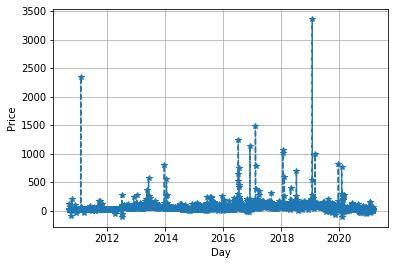

In [11]:
plt.plot(df_temp_daily.index, df_temp_daily['ElecPrice'], '--', marker = '*')
plt.grid()
plt.ylabel('Price')
plt.xlabel('Day')

In [12]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df_temp_daily['SysLoad'])

print(f'ADF Statistics: {adf_result[0]}')
print(f'P - Value: {adf_result[1]}')
print(f'No. of lags used: {adf_result[2]}')
print(f'No. of observation used: {adf_result[3]}')
print('Critical Values:')
for k, v in adf_result[4].items():
  print(f' {k}: {v}')

ADF Statistics: -3.6901589888366413
P - Value: 0.0042537255045741835
No. of lags used: 30
No. of observation used: 3803
Critical Values:
 1%: -3.432070672988693
 5%: -2.8623002987378547
 10%: -2.567174716967499


In [13]:
adf_result = adfuller(df_temp_daily['GasPrice'])

print(f'ADF Statistics: {adf_result[0]}')
print(f'P - Value: {adf_result[1]}')
print(f'No. of lags used: {adf_result[2]}')
print(f'No. of observation used: {adf_result[3]}')
print('Critical Values:')
for k, v in adf_result[4].items():
  print(f' {k}: {v}')

ADF Statistics: -2.902766697165181
P - Value: 0.045027212884625294
No. of lags used: 27
No. of observation used: 3806
Critical Values:
 1%: -3.4320693157877544
 5%: -2.8622996992165364
 10%: -2.5671743978048323


## UniVariate

In [56]:
df_uni = train.drop(['Tmax', 'SysLoad', 'GasPrice'], axis = 1)
df_uni['FullDate'] = df_uni.index
df_uni = df_uni.rename(columns = {'FullDate' : 'ds' , 'ElecPrice' : 'y'})
df_uni.reset_index(inplace = True)
df_uni.drop(['FullDate'], inplace = True, axis = 1)

In [57]:
model = Prophet()
model.fit(df_uni)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt9xr4in6/2cfgm31j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt9xr4in6/smfx76t3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91917', 'data', 'file=/tmp/tmpt9xr4in6/2cfgm31j.json', 'init=/tmp/tmpt9xr4in6/smfx76t3.json', 'output', 'file=/tmp/tmpt9xr4in6/prophet_modeln0ehwfqn/prophet_model-20230131193028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:30:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:30:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [58]:
future = model.make_future_dataframe(periods = len(test), freq = 'D')
forecast = model.predict(future)

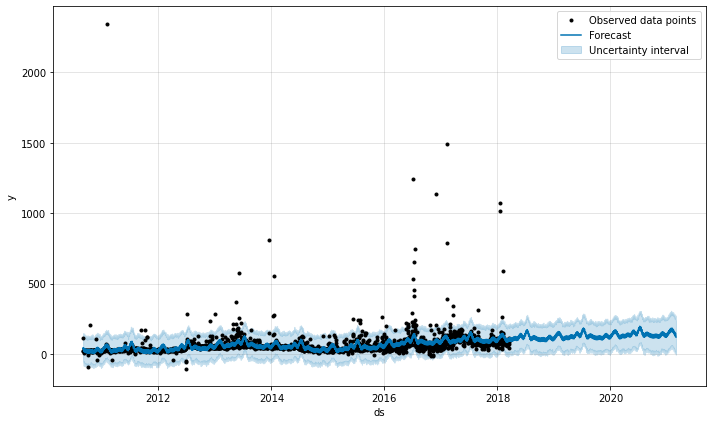

In [17]:
model.plot(forecast, uncertainty=True)
plt.legend()
plt.show()

In [73]:
predictions = forecast.iloc[-len(test):]['yhat']
actuals = test['ElecPrice']

In [60]:
print(f"RMSE: {round(rmse(predictions, actuals))}")
print('RMSE:',rmse(predictions, actuals))
print()
print(f"MAE: {round(meanabs(predictions, actuals))}")
print('MAE:', meanabs(predictions, actuals))

RMSE: 3208
RMSE: 3208.0625067777974

MAE: 1732
MAE: 1731.9703063637687


In [72]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [21]:
mean_absolute_percentage_error(actuals, predictions)

548.2447535166735

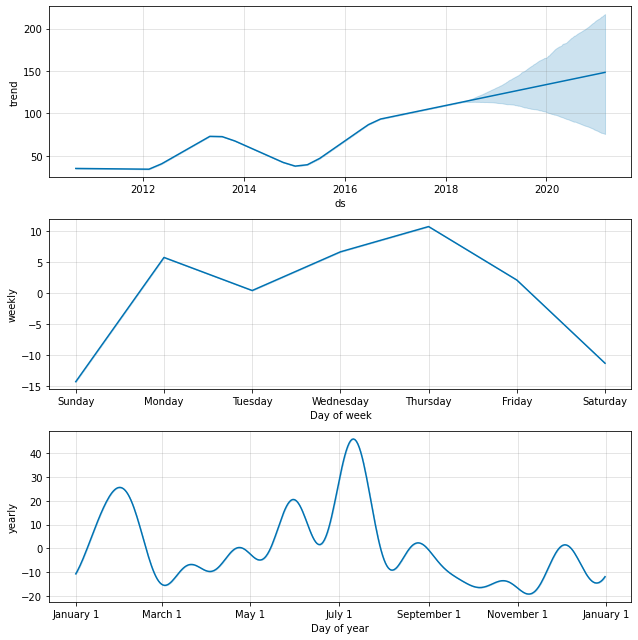

In [22]:
model.plot_components(forecast)
plt.show()

In [23]:
val_df = test['ElecPrice'].reset_index()
val_df.drop(['FullDate'], inplace = True, axis = 1)

In [24]:
predictions_val = predictions.reset_index()
predictions_val.drop(['index'], inplace = True, axis = 1)

In [25]:
final_df_uni = pd.concat((predictions_val, val_df['ElecPrice']), axis = 1)

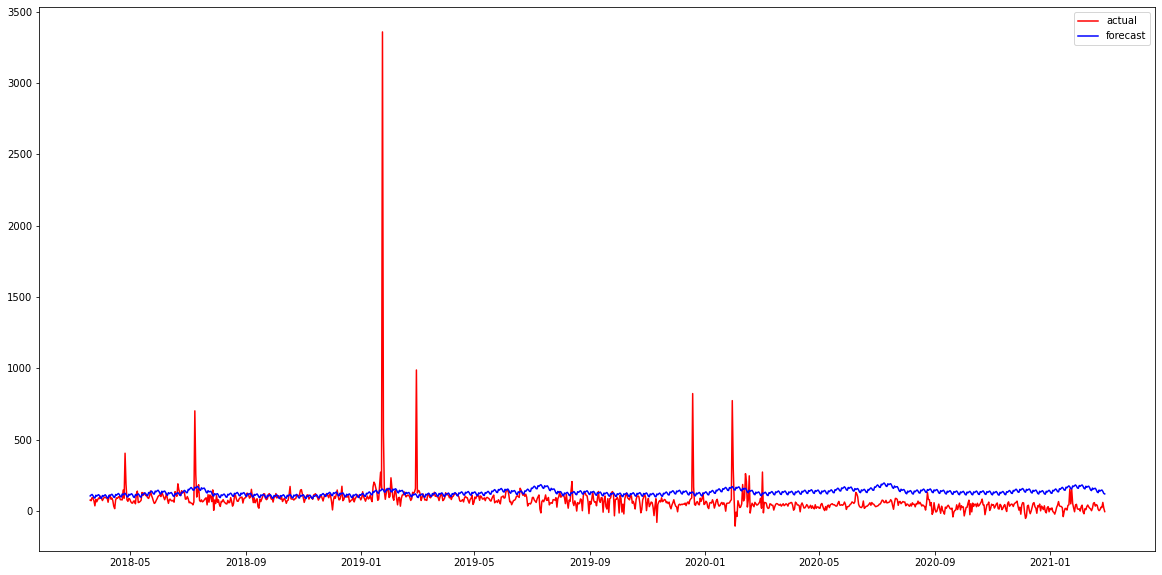

In [26]:
plt.figure(figsize = (20, 10))
plt.plot(test.index, final_df_uni['ElecPrice'], color = 'red', label = 'actual')
plt.plot(test.index, final_df_uni['yhat'], color = 'blue', label = 'forecast')
plt.legend()

## MultiVariate

In [66]:
df_multi = train.copy()
df_multi['FullDate'] = df_multi.index
df_multi = df_multi.rename(columns = {'FullDate' : 'ds' , 'ElecPrice' : 'y', 'SysLoad' : 'add1', 'Tmax' : 'add2', 'GasPrice' : 'add3'})
df_multi.reset_index(inplace = True)
df_multi.drop(['FullDate'], inplace = True, axis = 1)
df_multi.head()

,add2,add1,add3,y,ds
0,379.2,41565.380,88.56,2751.700,2010-09-01
1,369.6,38898.990,88.56,570.810,2010-09-02
2,439.2,41665.760,106.80,504.975,2010-09-03
3,328.8,35638.085,81.36,502.275,2010-09-04
4,357.6,35611.410,106.80,500.555,2010-09-05


In [67]:
model_multi = Prophet()
model_multi.add_regressor('add1')
model_multi.add_regressor('add2')
model_multi.add_regressor('add3')
model_multi.fit(df_multi)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt9xr4in6/dmn8b2iu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt9xr4in6/ruew1zpe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94346', 'data', 'file=/tmp/tmpt9xr4in6/dmn8b2iu.json', 'init=/tmp/tmpt9xr4in6/ruew1zpe.json', 'output', 'file=/tmp/tmpt9xr4in6/prophet_modelhy5cpsif/prophet_model-20230131193127.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:31:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:31:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [29]:
future_multi = model_multi.make_future_dataframe(periods = len(test), freq = 'D')

In [68]:
df_temp_daily_1 = df_temp_daily.drop(['ElecPrice'], axis = 1)
df_temp_daily_1['FullDate'] = df_temp_daily_1.index
df_temp_daily_1 = df_temp_daily_1.rename(columns = {'FullDate' : 'ds' , 'SysLoad' : 'add1', 'Tmax' : 'add2', 'GasPrice' : 'add3'})
df_temp_daily_1.reset_index(inplace = True)
df_temp_daily_1.drop(['FullDate'], inplace = True, axis = 1)

In [69]:
df_multi_temp = pd.merge(future_multi, df_temp_daily_1[['ds', 'add1', 'add2', 'add3']], on = 'ds', how = 'inner')
forecast_multi = model_multi.predict(df_multi_temp)

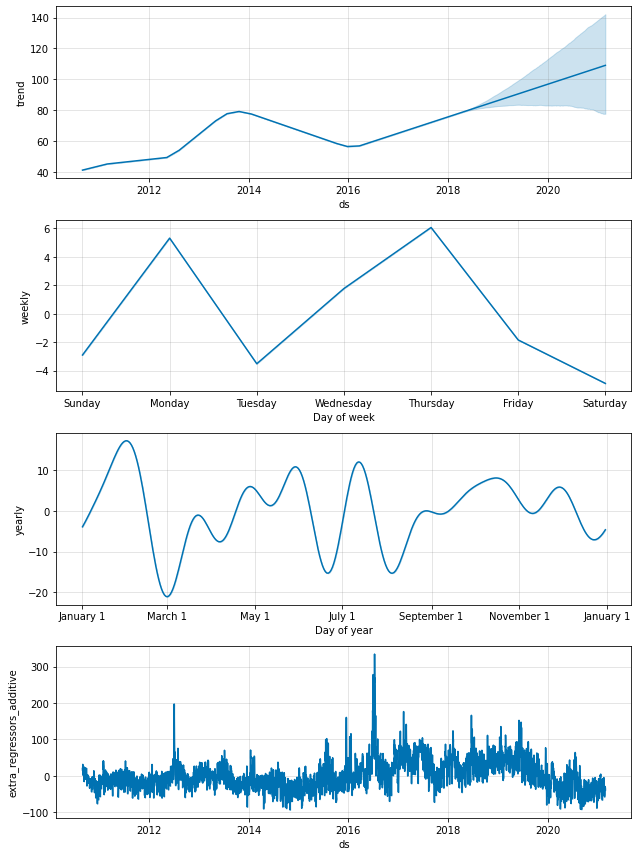

In [32]:
model_multi.plot_components(forecast_multi)
plt.show()

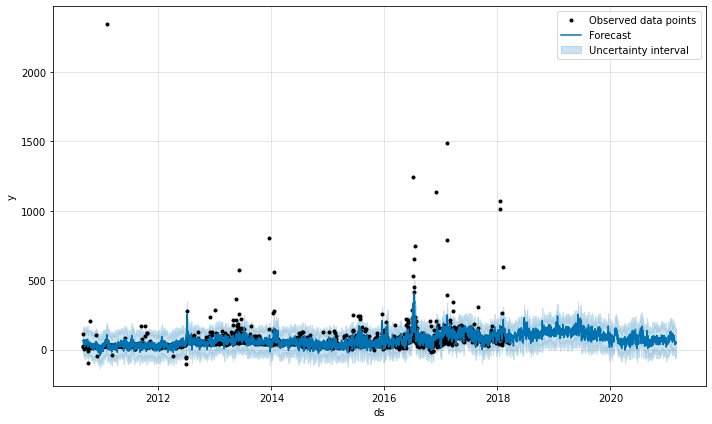

In [33]:
model_multi.plot(forecast_multi, uncertainty=True)
plt.legend()
plt.show()

In [74]:
predictions_m = forecast_multi.iloc[-len(test):]['yhat']
actuals_m = test['ElecPrice']

In [71]:
print(f"RMSE: {round(rmse(predictions_m, actuals_m))}")
print('RMSE:',rmse(predictions_m, actuals_m))
print()
print(f"MAE: {round(meanabs(predictions_m, actuals_m))}")
print('MAE:', meanabs(predictions_m, actuals_m))

RMSE: 2708
RMSE: 2707.60523794587

MAE: 986
MAE: 985.9939493038265


In [36]:
mean_absolute_percentage_error(actuals_m, predictions_m)

233.3746705189672

In [37]:
predictions_val_multi = predictions_m.reset_index()
predictions_val_multi.drop(['index'], inplace = True, axis = 1)

In [38]:
final_df_multi = pd.concat((predictions_val_multi, val_df['ElecPrice']), axis = 1)

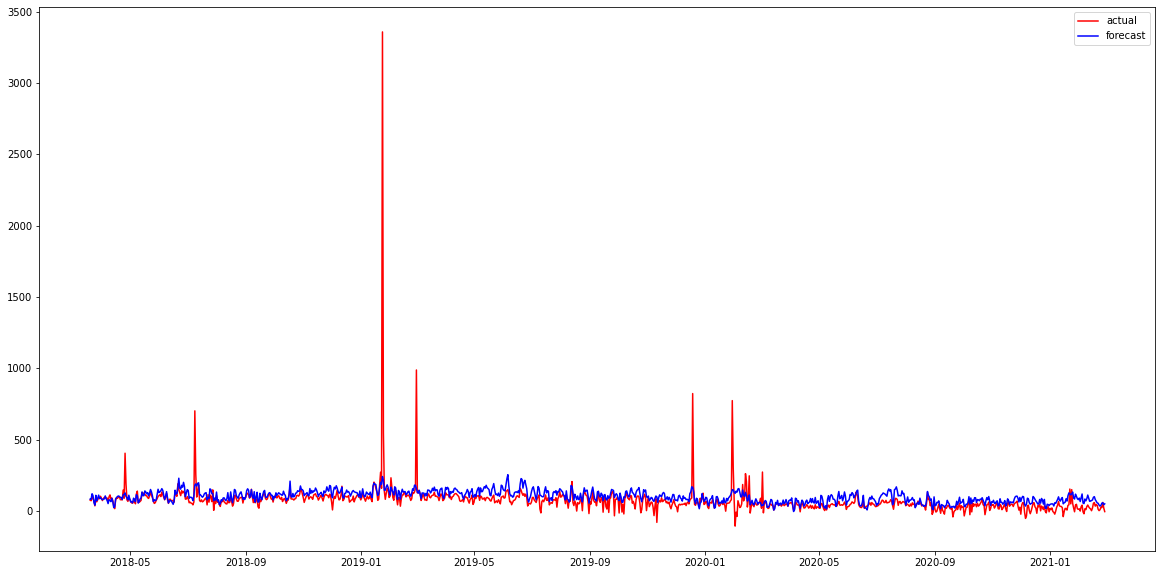

In [39]:
plt.figure(figsize = (20, 10))
plt.plot(test.index, final_df_multi['ElecPrice'], color = 'red', label = 'actual')
plt.plot(test.index, final_df_multi['yhat'], color = 'blue', label = 'forecast')
plt.legend()

## Custom

In [40]:
df_multi_1 = train.copy()
df_multi_1['FullDate'] = df_multi_1.index
df_multi_1.drop(['Tmax'], inplace = True, axis = 1)
df_multi_1 = df_multi_1.rename(columns = {'FullDate' : 'ds' , 'ElecPrice' : 'y', 'SysLoad' : 'add1', 'GasPrice' : 'add3'})
df_multi_1.reset_index(inplace = True)
df_multi_1.drop(['FullDate'], inplace = True, axis = 1)
df_multi_1.head()

,add1,add3,y,ds
0,1731.890833,3.69,114.654167,2010-09-01
1,1620.791250,3.69,23.783750,2010-09-02
2,1736.073333,4.45,21.040625,2010-09-03
3,1484.920208,3.39,20.928125,2010-09-04
4,1483.808750,4.45,20.856458,2010-09-05


In [41]:
model_multi_1 = Prophet()
model_multi_1.add_regressor('add1')
model_multi_1.add_regressor('add3')
model_multi_1.fit(df_multi_1)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt9xr4in6/k370blc_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt9xr4in6/by8hsqvj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84045', 'data', 'file=/tmp/tmpt9xr4in6/k370blc_.json', 'init=/tmp/tmpt9xr4in6/by8hsqvj.json', 'output', 'file=/tmp/tmpt9xr4in6/prophet_modelu85lf1o_/prophet_model-20230131192832.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:28:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:28:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [84]:
df_multi_temp_1 = pd.merge(future_multi, df_temp_daily_1[['ds', 'add1', 'add2', 'add3']], on = 'ds', how = 'inner')
df_multi_temp_1.drop(['add2'], inplace = True, axis = 1)
forecast_multi_1 = model_multi_1.predict(df_multi_temp_1)

In [ ]:
predictions_m_1 = forecast_multi_1.iloc[-len(test):]['yhat']
actuals_m_1 = test['ElecPrice']

In [ ]:
mean_absolute_percentage_error(actuals_m_1, predictions_m_1)

230.84192161811873